# Metropolis Algorithm Markov Chain Monte Carlo

In [186]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import functools
import pdb

First example found here: https://arxiv.org/pdf/1504.01896.pdf

In [6]:
def sinus_normal(x):
    return np.sin(x)**2 * np.sin(2*x)**2 * sp.norm.pdf(x)

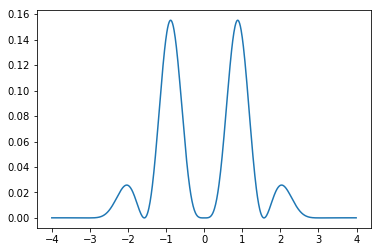

In [15]:
test = [sinus_normal(x) for x in np.arange(-4.,4.,0.01)]
plt.plot(np.arange(-4.,4.,0.01), test)
plt.show()

**Why does the Metropolis(-Hastings) algorithm work for our posterior distribution?**

The problem with the posterior distribution is that the denominator is hard to calculate (or *intractable*). Fortunately for us, the idea of the Metropolis sampling is to jump to a proposed value $x'$ if the *relative* density at that point is higher. That means that we evaluate $P(x'|D)/P(x|D)$. Remember that $P(x|D) = \frac{P(D|x) P(x)}{P(D)}$, where the part $P(D)$ is intractable. For the ratio, we calculate 

$$ \frac{ 
\frac{P(D|x') P(x')}{P(D)}}{
\frac{P(D|x) P(x)}{P(D)}
} = \frac{ 
P(D|x') P(x')}{
P(D|x) P(x)
}.$$

The complicated part $P(D)$ drops out, because it is the same for any parameter choice of our model and we can sample as much as we want without having to calculate it.

In [92]:
def metropolis(start_value, n_iter, density, proposal_distribution):
    chain = np.zeros([n_iter])
    chain_acceptance_ratio = np.zeros([n_iter])
    
    x = start_value
    x_density = density(x)
    chain[0] = x
    
    for i in range(1,n_iter):
        candidate_x = np.float64(proposal_distribution(x)) # naturally handle /0
        candidate_x_density = np.float64(density(candidate_x))
        
        acceptance_ratio = candidate_x_density/x_density
        if np.isnan(acceptance_ratio):
            acceptance_ratio = 0.
        acceptance_ratio = min(acceptance_ratio, 1)
        
        random_u = np.random.uniform(0,1)
        if random_u <= acceptance_ratio:
            x = candidate_x
            x_density = candidate_x_density
        
        chain[i] = x
        chain_acceptance_ratio[i] = acceptance_ratio
    
    return chain,chain_acceptance_ratio

We have a way to evaluate a proposal by the acceptance ratio, but we haven't defined a way to pick a candidate $x'$ yet. This choice is important. 

If we jump to much between candidates, e.g. from 1 to 100, the chance is high that we end up in areas with low probability density and won't accept the proposal. If we jump too little, e.g. from 1 to 1.005, we will have to jump many times to explore the full range between -4 and 4.

A good proposal distribution generates a random walk by jumping from the last point in the chain and has a jump size that leads to an acceptance rate that is not too high and not too low. 

TODO: Roberts et al. (1997) suggest that for a Gaussian proposal distribution the optimal acceptance rate should be 0.25. 
*Roberts, G., Gelman, A., and Gilks, W. (1997). “Weak convergence and optimal scaling of
random walk Metropolis algorithms.” Ann. Applied Prob., 7: 110–120.*

In [122]:
def normal_proposal(x):
    return np.random.normal(x, 1) # The precision defines the jump size

In [100]:
test,alpha = metropolis(0, 10000, sinus_normal, normal_proposal)

/Users/maj/anaconda/envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


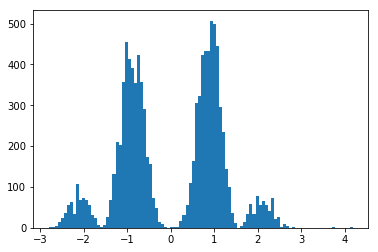

In [104]:
plt.hist(test, bins=100)
plt.show()

**What happens if we pick a start value that's completely off?**

As long as the proposal distribution has a reasonable chance to jump to a point with density above zero, then the chain will eventually reach the interesting part of the distribution and explore it. Since the path to the areas with the highest density may take some iterations, it is common practice to drop the first *n* observations, which are called *burn-in*.

In [118]:
test,alpha = metropolis(10, 10000, sinus_normal, normal_proposal)

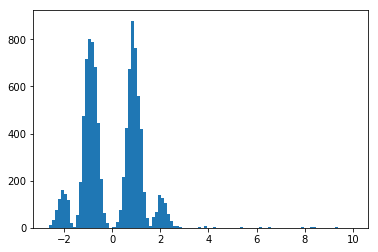

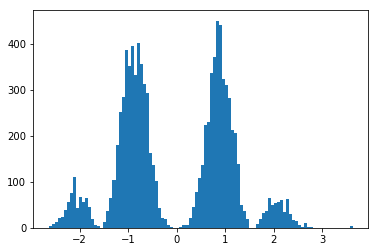

In [121]:
plt.hist(test, bins=100) # Start value off, no burn-in
plt.show()
plt.hist(test[500:], bins=100) # With a burn-in of 500
plt.show()

TODO: Extend to Metropolis Hastings by including the ratio q(x|y)/q(y|x) to correct for asymmetric proposal distributions

TODO: Look at autocorrelation and explain effective sample size 

## Regression example

Let's apply this to a model that we are comfortable with: Regression. As in any statistics class, we'll assume that the come from the following data generating process:

$y_i = x_i'\beta + \epsilon_i$ with $\epsilon \sim N(0, \sigma^2)$

We will ignore the constant $\beta_0$ to keep things as simple as possible, but we can image that the data is standardized to mean 0 or includes a column $1_n$.

In the Bayesian setting, it's convenient to write this down as

$y_i \sim N(x_i'\beta, \sigma^2)$. 

Aside: Where did the $\epsilon$ go? If there were no error, then $y$ would be completely determined by $x$. The error was just another way of formalizing that $y$ tends to fall close to some value that is determined by the combination of $x$. How far away it tends to fall away from the value explained by $x$ is formalized by a variance $\sigma^2$, which we see in the definition of $\epsilon$ and in the definition of $y$ for the Bayesian model specification. 

Because many of the derivations work out nicer if we don't use $\sigma^2$ but its inverse, we will replace $\sigma^2$ with $\tau = 1/\sigma^2$ from now on. $\tau$ is called the *precision* and in the cause of our $y$ it describes how precisely the $x$s predict $y$.

In [253]:
def generate_data(n, beta, tau):
    X = np.random.normal(0,2,size=[n, len(beta)])
    # ATTENTION: numpy works with the standard deviation (scale) instead of the variance
    y = np.dot(X,beta) + np.random.normal(0, 1/np.sqrt(tau))
    return X, y

In [254]:
X_train, y_train = generate_data(5000, [-1, 1, 2], 1)

Derive the likelihood

TODO: Show the full derivation step-by-step

In [255]:
def regression_log_likelihood(y, X, beta, tau):
    
    log_likelihood_x = sp.norm.logpdf(y,  # True value
                loc=np.dot(X,beta), # Predicted value
                scale= 1/np.sqrt(tau) # Estimated error variance
                )          
                                      
    log_likelihood = np.sum(log_likelihood_x)
    return log_likelihood

regression_log_likelihood = functools.partial(regression_log_likelihood, y=y_train, X=X_train)

Define the priors

TODO: Link to explanation of how to choose priors

In [256]:
def regression_log_prior(beta,tau):
    beta_prior_probability = np.sum(sp.norm.logpdf(beta, 
                                            loc=[0]*np.ones(len(beta)), # Pull towards 0
                                            scale = 1/np.sqrt([3])*np.ones(len(beta))))
    # Gamma distribution is always positive
    #sigma_prior_probability = sp.gamma.logpdf(sigma2, a=1, scale=0.5)
    #tau_prior_probability = sp.truncnorm.logpdf(tau, a=0, b=np.inf, 
    #                                            loc=0,scale=1/np.sqrt(0.25))
    tau_prior_probability = sp.uniform.logpdf(tau, 0, 100)
    log_likelihood = np.sum([beta_prior_probability, tau_prior_probability])
    return log_likelihood

Define a proposal distribution

For the random walk metropolis algorithm, we pick a candidate given the previous value.
The variance/precision of the proposal distribution determines how far we jump away from the previous value. How far we jump influences how many of the candidates we will accept. We expect that jumping far from the previous (and therefore previously accepted) value will lead to a lower acceptance rate. We expect that jumping very close to the previous value will make us move very slowly around the likely values. 

TODO: Explain that better.

In [257]:
def regression_proposal(beta, tau):
    beta = np.random.normal(beta, 1/np.sqrt(10000))
    tau = np.random.normal(loc=tau, scale=1/np.sqrt(4000))
    return beta,tau

The Metropolis Algorithm
We don't correct for asymmetric proposal distributions here, which would be the extension proposed by Hastings. We don't have to, because our proposal distributions are *Gaussian/Normal* and the bell curve is symmetric. 


We calculate the acceptance ratio $\alpha$ as a measure of how much more likely the observed data is given the proposed candidate parameter values for $\beta$ and $\tau$ than it is under the previous values: 

$\alpha = \frac{p(\beta_{candidate},\tau_{candidate}|y,X)}{p(\beta_{old},\tau_{old}|y,X)}$

$p(\beta,\tau|y,X)$ is the *posterior distribution*, our belief that the parameters take a certain value after we have seen the data. By the Bayesian formula, 

$p(\beta,\tau|y,X) = \frac{p(y,X|\beta,\tau) * p(\beta,\tau)}{p(X,y)}$. 

As usual when working with the Bayes formula, $p(X,y)$ is hard to calculate. Fortunately for us, it cancels out in the calculation for $\alpha$. We therefore calculate $p(y,X|\beta,\tau) * p(\beta,\tau)$ for the candidate and old values of the parameter in the code.

In [258]:
def metropolis(start_value_beta, start_value_tau, 
               n_iter, likelihood_distribution, prior_distribution,proposal_distribution):
    chain = np.zeros([n_iter, len(start_value_beta)+len(start_value_tau)])
    chain_acceptance_ratio = np.zeros([n_iter])
    
    # The posterior p(b,t|X,y) is p(y,X|b,t) * p(b,t)
    # log p(b,t|X,y) is log p(y,X|b,t) + log p(b,t)
    def posterior(beta, tau):
        log_likelihood = likelihood_distribution(beta=beta, tau=tau)
        log_prior = prior_distribution(beta,tau)
        log_posterior = np.sum([log_likelihood, log_prior])
        return log_posterior
    
    beta = start_value_beta
    tau = start_value_tau
    current_posterior = posterior(beta=beta, tau=tau)
    chain[0,:] = np.concatenate([beta,tau])
    
    #pdb.set_trace()
    
    for i in range(1,n_iter):
        candidate_beta, candidate_tau = proposal_distribution(beta,tau) 
        candidate_posterior = posterior(beta=candidate_beta, tau=candidate_tau)
        
        # Careful here: 
        # ln(acc_ratio) = ln(post'/post) = ln_post - ln_post
        # -> acc_ratio = exp(ln_post' - ln_post)
        acceptance_ratio = np.exp(candidate_posterior - current_posterior)
        
        # Limit to maximum 1 since it should be probability of acceptance
        acceptance_ratio = min(acceptance_ratio, 1)
        
        # Acceptance as a 0/1 choice with probability equal to acceptance ratio
        accept_bin = np.random.binomial(n=1,p=acceptance_ratio)
        if accept_bin == 1:
            # Exchange the old values for the proposed
            beta, tau = candidate_beta, candidate_tau
            current_posterior = candidate_posterior
        
        # Save the values at iteration i
        chain[i,:] = np.append(beta,tau)
        chain_acceptance_ratio[i] = acceptance_ratio
    
    return chain,chain_acceptance_ratio

In [264]:
test,alpha = metropolis(start_value_beta = np.array([0,0,0]), 
                        start_value_tau = np.array([0.5]), 
                        n_iter = 30000, 
                        likelihood_distribution = regression_log_likelihood,
                        prior_distribution = regression_log_prior,
                        proposal_distribution = regression_proposal)

Check the acceptance ratio. The acceptance ratio x number of iterations is the number of samples that we do not throw away. 

In [268]:
np.mean(alpha)

0.1927171993682289

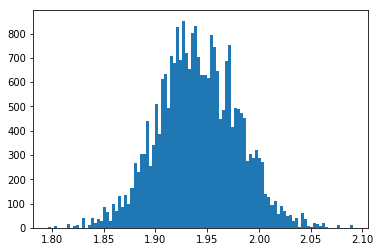

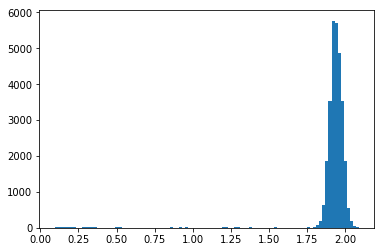

In [270]:
plt.hist(test[5000:,3], bins=100) # Start value off, no burn-in
plt.show()
plt.hist(test[500:, 3], bins=100) # With a burn-in of 500
plt.show()

In [267]:
np.mean(test[5000:,3])

1.9411138531046006

TODO: We seem to consistently and substantially overestimate the variance to 2 instead of 1. Why is that?

TODO: Are independent Metropolis-Hastings at all interesting? What happens to the Hastings correction in the independent case (it doesn't drop out) --> This actually explains why the acceptance rate becomes 1 in Gibbs sampling (where g() = q())